# Lecture 15: Outliers and Imputation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

sns.reset_orig()
sns.set(font_scale=1.5)
%matplotlib inline

---

# Gaussian Outliers

In [2]:
%reload_ext sql
%sql postgresql://localhost:5432/postgres

There's a new jupysql version available (0.10.10), you're running 0.10.0. To upgrade: pip install jupysql --upgrade
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [3]:
%sql SELECT setseed(0.42) -- to fix randomness

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

setseed
""


Just like a Python package, we need to import `tablefunc` in order to use the `normal_rand` function.

In [4]:
%sql CREATE EXTENSION IF NOT EXISTS tablefunc;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Assume our datapoints are truly Normal. Simulate them in `observations`.
* 1000 datapoints, $\mu = 50, \sigma = 5$.

In [5]:
%sql DROP TABLE IF EXISTS observations CASCADE;
%sql CREATE TABLE observations AS \
     SELECT normal_rand AS x \
     FROM normal_rand(1000, 50, 5);

results = %sql SELECT x FROM observations;

Running query in 'postgresql://localhost:5432/postgres'

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

Running query in 'postgresql://localhost:5432/postgres'

1000 rows affected.

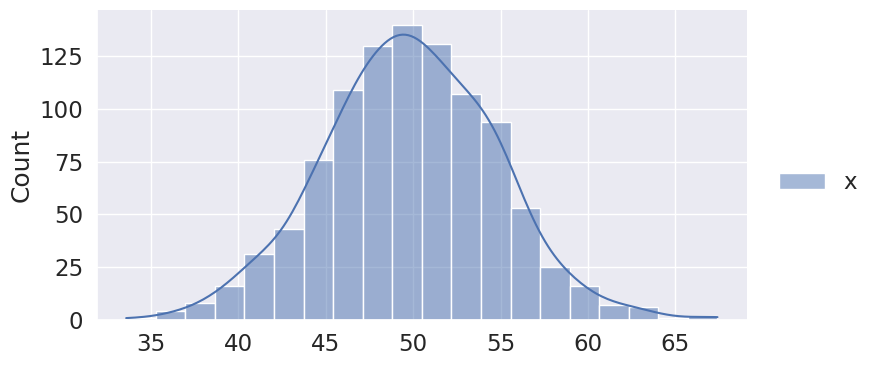

In [6]:
sns.displot(results.dict(), fill=True, kde=True, bins=20,
            height=4, aspect=2)

Construct a view called `normal_outliers` using the **2 sigma** metric.

In [7]:
# construct the view
%%sql
CREATE OR REPLACE VIEW normal_outliers AS
WITH bounds AS (
   SELECT avg(x) - 2*stddev(x) AS lo,
   avg(x) + 2*stddev(x) AS hi
   FROM observations
)
SELECT x AS outlier
FROM observations o, bounds b 
WHERE x NOT BETWEEN b.lo AND b.hi;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [8]:
# query the view
%sql SELECT * FROM normal_outliers;

Running query in 'postgresql://localhost:5432/postgres'

48 rows affected.

outlier
63.86320318151008
36.646579392783515
60.553093656123345
38.558570226597766
39.93605975008588
39.50334165073182
59.94090169915566
65.50773752644888
60.106996705922434
60.16178073333252


## What does this code do?

Running query in 'postgresql://localhost:5432/postgres'

1952 rows affected.

(30.0, 70.0)

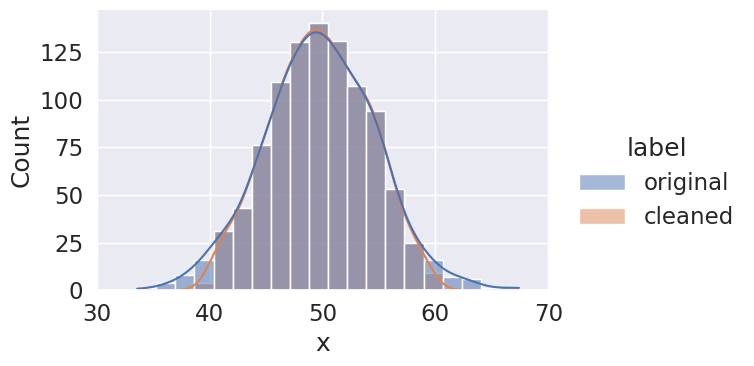

In [9]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
            height=4, aspect=1.5)
plt.xlim(30, 70)

<br/><br/><br/>
<br/><br/><br/>
<br/><br/><br/>

## Choices [hidden]

**A.**

Running query in 'postgresql://localhost:5432/postgres'

1046 rows affected.

(30.0, 70.0)

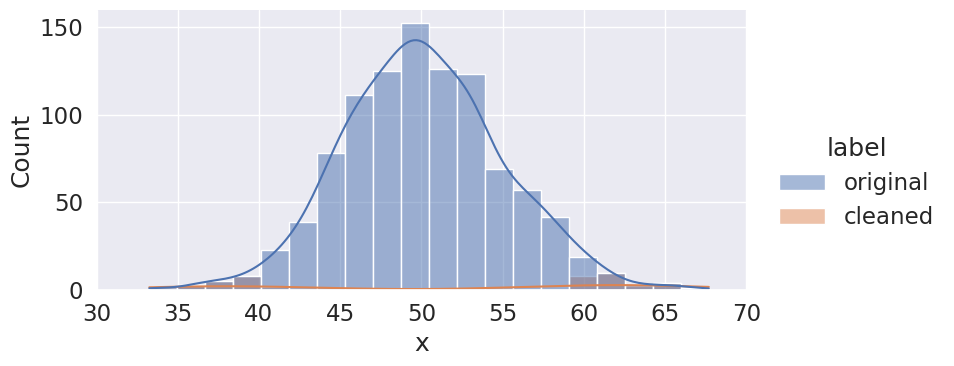

In [11]:
## plots outliers and original
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**B.**

Running query in 'postgresql://localhost:5432/postgres'

1954 rows affected.

(30.0, 70.0)

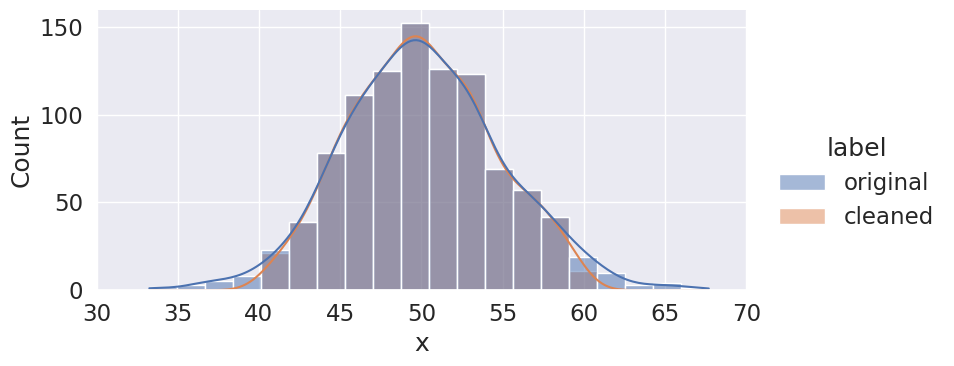

In [12]:
# correct
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**C.**

Running query in 'postgresql://localhost:5432/postgres'

1908 rows affected.

(30.0, 70.0)

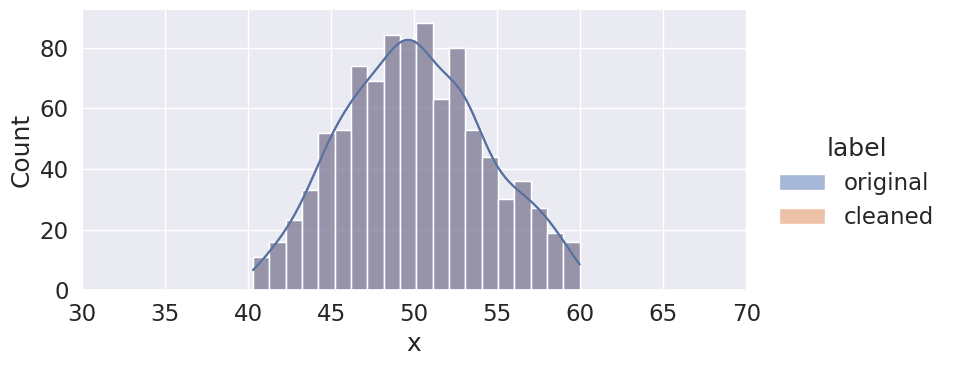

In [13]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers) \
               UNION ALL \
               SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

**D.**

Running query in 'postgresql://localhost:5432/postgres'

954 rows affected.

(30.0, 70.0)

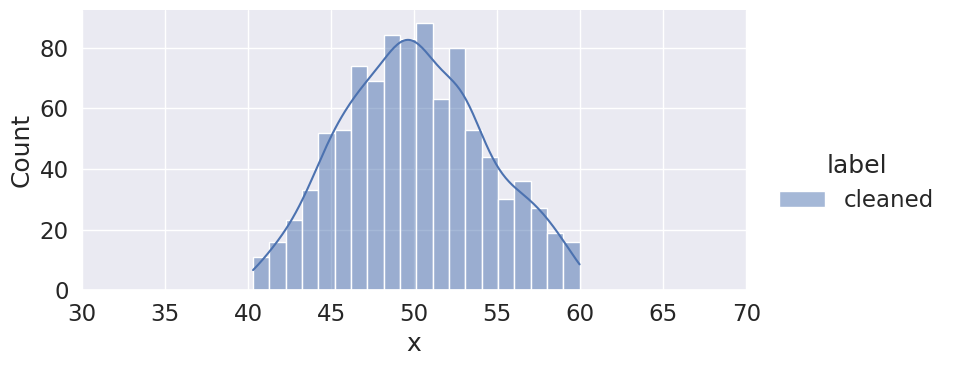

In [14]:
results = %sql SELECT x, 'cleaned' AS label \
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=20,
                        height=4, aspect=2)
plt.xlim(30, 70)

## What if we suddenly had extremes?

Set the max to be 10 times its original value

In [11]:
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

In [12]:
%sql SELECT min(x), max(x) FROM observations

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

min,max
33.59621477959317,6740.3780625490435


Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 700.0)

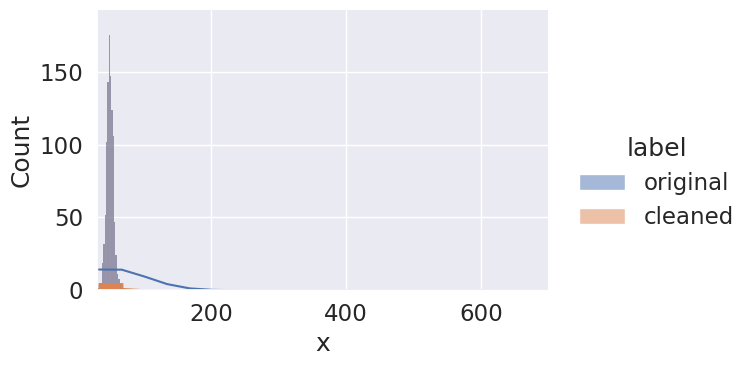

In [13]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 700)

Running query in 'postgresql://localhost:5432/postgres'

1999 rows affected.

(30.0, 70.0)

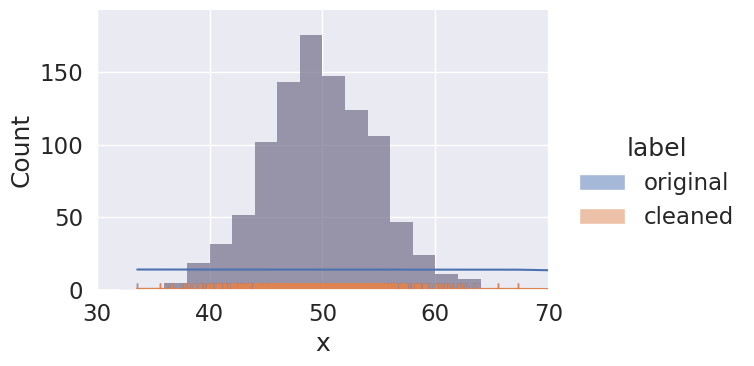

In [14]:
results = %sql SELECT x, 'original' AS label \
               FROM observations \
               UNION ALL \
               SELECT x, 'cleaned' AS label\
               FROM observations \
               WHERE x NOT IN \
                   (SELECT * FROM normal_outliers)
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

In [15]:
## reset before moving on
%sql UPDATE observations SET x = x/10 \
      WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

# Winsorization

In [16]:
import numpy as np

In [17]:
arr = np.array([92, 19, 101, 58, 1053, 91, 26, 78, 10, 13, -40, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr

array([  92,   19,  101,   58, 1053,   91,   26,   78,   10,   13,  -40,
        101,   86,   85,   15,   89,   89,   28,   -5,   41])

In [18]:
np.mean(arr), np.median(arr)

(101.5, 68.0)

In [19]:
np.percentile(arr, 95, method='nearest')

101

In [20]:
np.percentile(arr, 5, method='nearest')

-5

In [21]:
arr_winsorized = np.array([92, 19, 101, 58, 101, 91, 26, 78, 10, 13, -5, 101, 86, 85, 15, 89, 89, 28, -5, 41])
arr_winsorized

array([ 92,  19, 101,  58, 101,  91,  26,  78,  10,  13,  -5, 101,  86,
        85,  15,  89,  89,  28,  -5,  41])

In [22]:
np.mean(arr_winsorized), np.median(arr_winsorized)

(55.65, 68.0)

# Trimming vs. Winsorizatoin

In [23]:
%%sql
CREATE OR REPLACE VIEW p1p99 AS
SELECT percentile_cont(.01) WITHIN GROUP (ORDER BY x) AS p1,
           percentile_cont(.99) WITHIN GROUP (ORDER BY x) AS p99
      FROM observations;
SELECT * FROM p1p99;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

p1,p99
38.217148626836696,62.040141716041596


In [24]:
%%sql
CREATE OR REPLACE VIEW trimmed_observations AS
SELECT o.x, 'trimmed' AS label
  FROM observations o, p1p99 p
 WHERE o.x BETWEEN p.p1 AND p.p99
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

CREATE OR REPLACE VIEW trimmed_outliers AS
SELECT o.*
  FROM observations o, p1p99 p
 WHERE o.x NOT BETWEEN p.p1 AND p.p99;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

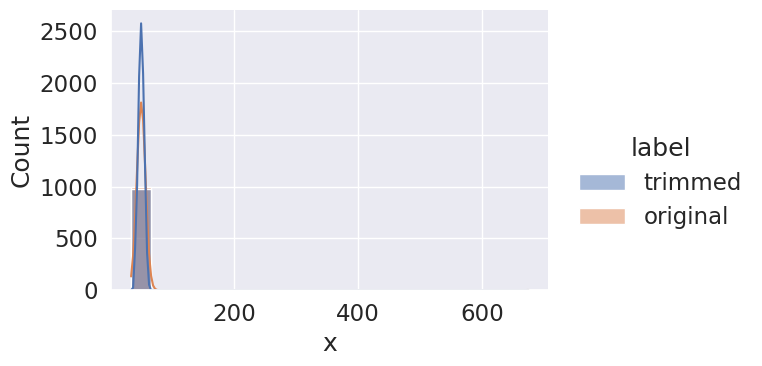

In [25]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist', hue='label', kde=True, bins=20,
           height=4, aspect=1.5)

## Does corruption affect?

In [26]:
# corrupt one value
%sql UPDATE observations SET x = x*10 \
      WHERE x = (SELECT MAX(x) FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

++
||
++
++

Turns out, we still have as many outliers, which we trim.

Because we are trimming based on the order of the data and not on the distribution statistics (mean/SD)

Running query in 'postgresql://localhost:5432/postgres'

1980 rows affected.

(30.0, 70.0)

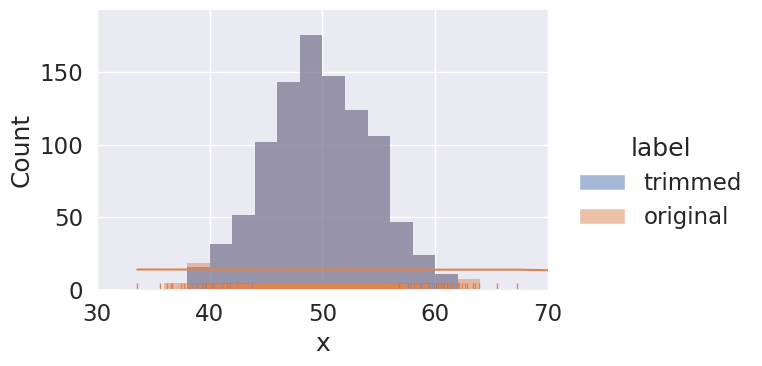

In [27]:
results = %sql SELECT * from trimmed_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

## Winsorization

In [32]:
## reset before moving on
# %sql UPDATE observations SET x = x*10 \
#       WHERE x = (SELECT MAX(x) FROM OBSERVATIONS);

In [28]:
%%sql
CREATE OR REPLACE VIEW winsorized_observations AS
SELECT CASE WHEN o.x BETWEEN p.p1 AND p.p99 THEN o.x
            WHEN o.x < p.p1 THEN p.p1
            WHEN o.x > p.p99 THEN p.p99
        END AS x,
      'winsorized' AS label
  FROM observations o, p1p99 p
UNION ALL
SELECT o.x, 'original' AS label
  FROM observations o;

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

2000 rows affected.

(30.0, 70.0)

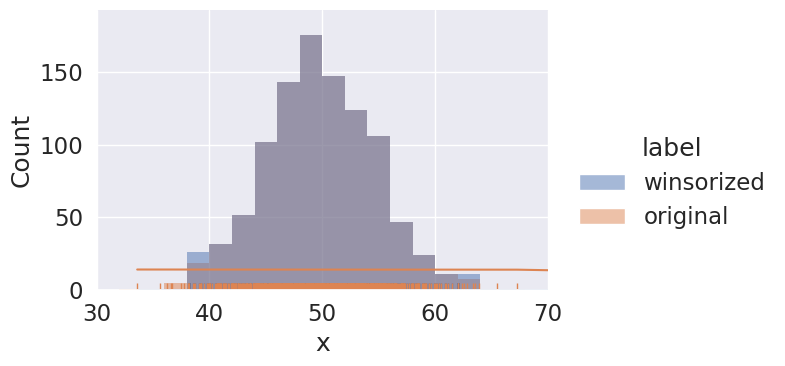

In [29]:
results = %sql SELECT * from winsorized_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)

In [30]:
%%sql 
SELECT 'orig' AS distribution, min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM observations
UNION ALL
SELECT 'winsorized', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM winsorized_observations WHERE label = 'winsorized'
UNION ALL 
SELECT 'trimmed', min(x),
       percentile_disc(.25) WITHIN GROUP (ORDER BY x) as p25,
       percentile_disc(.50) WITHIN GROUP (ORDER BY x) as median,
       percentile_disc(.75) WITHIN GROUP (ORDER BY x) as p75,
       max(x), avg(x), stddev(x), count(x) 
       FROM trimmed_observations WHERE label = 'trimmed';

Running query in 'postgresql://localhost:5432/postgres'

3 rows affected.

distribution,min,p25,median,p75,max,avg,stddev,count
orig,33.59621477959317,46.57964148700616,49.785040902390236,53.21941846410288,6740.3780625490435,56.48232441933681,211.63166295503495,1000
winsorized,38.217148626836696,46.57964148700616,49.785040902390236,53.21941846410288,62.040141716041596,49.802954090308916,4.8362044168032385,1000
trimmed,38.217850122184686,46.611384756296765,49.785040902390236,53.12833012729696,62.03987137686712,49.79630733355114,4.57885673603152,980


# Robustness, Mean, Median, Hampel X84

In [31]:
%%sql
-- percentile_disc returns an actual data value near the percentile
-- percentile_cont returns an interpolated value at the percentile
CREATE OR REPLACE VIEW median AS
(SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median
  FROM observations);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

In [32]:
%%sql
CREATE OR REPLACE VIEW mad AS
WITH
absdevs AS
(SELECT abs(x - median) as d
   FROM observations, median)
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY d) as mad
  FROM absdevs;
    
SELECT median, mad
  FROM median, mad;

Running query in 'postgresql://localhost:5432/postgres'

1 rows affected.

median,mad
49.785040902390236,3.293753855870449


In [33]:
%%sql
CREATE OR REPLACE VIEW hampelx84x2_observations AS
SELECT o.x,
      'hampelx84x2' AS label
  FROM observations o, median, mad
 WHERE o.x BETWEEN (median-2*1.4826*mad) AND (median+2*1.4826*mad)
UNION ALL
SELECT o.x, 'orig' AS label
  FROM observations o;

CREATE OR REPLACE VIEW Hampel84x2_outliers AS
SELECT x
  FROM observations o, median, mad
 WHERE x NOT BETWEEN (median - 2*1.4826*mad) AND (median + 2*1.4826*mad);

Running query in 'postgresql://localhost:5432/postgres'

++
||
++
++

Running query in 'postgresql://localhost:5432/postgres'

1950 rows affected.

(30.0, 70.0)

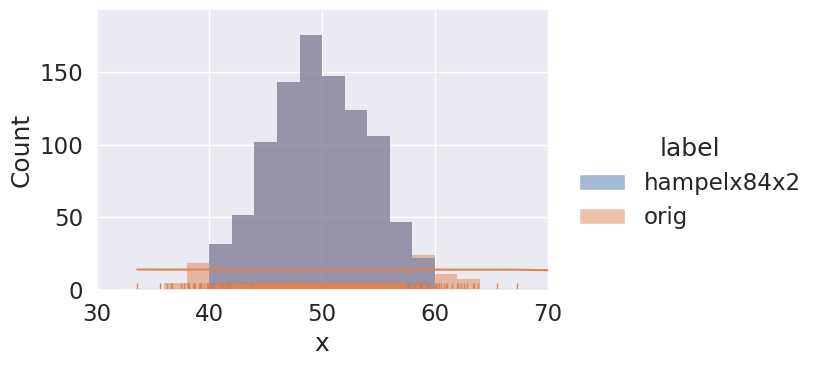

In [34]:
results = %sql SELECT * FROM hampelx84x2_observations
sns.displot(results.dict(), x="x", kind='hist',
            hue='label', kde=True, bins=np.linspace(32, 70, 20),
            height=4, aspect=1.5, rug=True)
plt.xlim(30, 70)